In [1]:
!pip install kaggle
!pip install keras
!pip install tqdm
!pip install imageio

In [0]:
!mkdir .kaggle
f = open(".kaggle/kaggle.json", "w")
f.write('{"username":"bkkaggle","key":"b167cae7e4f9cb983e5dfc0e1d47c661"}')
f.close() 

In [2]:
!cat .kaggle/kaggle.json

{"username":"bkkaggle","key":"b167cae7e4f9cb983e5dfc0e1d47c661"}

In [0]:
!kaggle competitions download -c data-science-bowl-2018

In [0]:
!unzip .kaggle/competitions/data-science-bowl-2018/stage1_train.zip -d .kaggle/competitions/data-science-bowl-2018/train
!unzip .kaggle/competitions/data-science-bowl-2018/stage1_test.zip -d .kaggle/competitions/data-science-bowl-2018/test
!unzip .kaggle/competitions/data-science-bowl-2018/stage1_train_labels.csv.zip -d .kaggle/competitions/data-science-bowl-2018/labels

In [3]:
import numpy as np

import keras
import tensorflow as tf

Using TensorFlow backend.


In [4]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
import os
import sys

import pandas as pd
import numpy as np
from tqdm import tqdm

import keras
import keras.backend as K

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, Dropout, concatenate, Lambda


from numpy.random import seed
seed(1)

from tensorflow import set_random_seed
set_random_seed(2)

In [0]:
from skimage import io
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage.filters import threshold_otsu
from skimage.morphology import label

from sklearn.metrics.pairwise import pairwise_distances

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

%matplotlib inline

import pathlib
import imageio

In [0]:
train_path = '.kaggle/competitions/data-science-bowl-2018/train/'
test_path = '.kaggle/competitions/data-science-bowl-2018/test/'

In [0]:
train_ids = next(os.walk(train_path))[1]
test_ids = next(os.walk(test_path))[1]

In [0]:
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = label(y_true_in > 0.5)
    y_pred = label(y_pred_in > 0.5)
    
    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.array(np.mean(metric), dtype=np.float32)

def my_iou_metric(label, pred):
    metric_value = tf.py_func(iou_metric_batch, [label, pred], tf.float32)
    return metric_value

  
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1.) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [10]:
x_train = np.zeros((len(train_ids), 128, 128, 3))
y_train = np.zeros((len(train_ids), 128, 128, 1))

for i, index in tqdm(enumerate(train_ids), total=len(train_ids)):
    img = imageio.imread(train_path + '/' + index + '/images/' + index + ".png")
    img = img[:,:,:3]
    img = resize(img, (128, 128, 3), mode='constant')
        
    masks = np.zeros((128, 128, 1))
    mask_files = next(os.walk(train_path + index + '/masks/'))[2]
    
    for mask in mask_files:
        mask = imageio.imread(train_path + '/' + index + '/masks/' + mask)
        mask = resize(mask, (128, 128, 1), mode='constant')
        masks = np.maximum(masks, mask)
    
    x_train[i] = img
    y_train[i] = masks

100%|██████████| 670/670 [03:12<00:00,  3.48it/s]


In [11]:
x_test = np.zeros((len(test_ids), 128, 128, 3))

for i, index in tqdm(enumerate(test_ids), total=len(test_ids)):
    img = imageio.imread(test_path + '/' + index + '/images/' + index + ".png")
    img = img[:,:,:3]
    img = resize(img, (128, 128, 3), mode='constant')
    
    x_test[i] = img

100%|██████████| 65/65 [00:01<00:00, 56.38it/s]


In [12]:
x_test_sizes = []

for i, index in tqdm(enumerate(test_ids), total=len(test_ids)):
    img = imageio.imread(test_path + '/' + index + '/images/' + index + ".png")
    x = img.shape[0]
    y = img.shape[1]
    
    x_test_sizes.append([x, y])

100%|██████████| 65/65 [00:00<00:00, 145.31it/s]


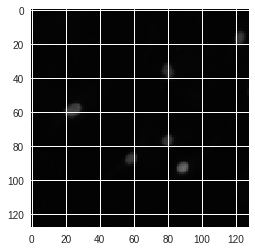

In [13]:
plt.imshow(x_train[0], cmap='viridis')

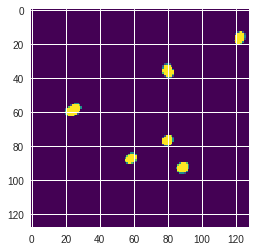

In [14]:
plt.imshow(y_train[0].reshape(128, 128), cmap='viridis')

In [0]:
input_conv = Input((128, 128, 3))

s = Lambda(lambda x: x / 255) (input_conv)

# smaller
conv_1 = Conv2D(16, (3,3), kernel_initializer='he_normal', activation='relu', padding='same')(s)
conv_2 = Conv2D(16, (3,3), kernel_initializer='he_normal', activation='relu', padding='same')(conv_1)
pooling_1 = MaxPooling2D((2,2))(conv_2)

conv_3 = Conv2D(32, (3,3), kernel_initializer='he_normal', activation='relu', padding='same')(pooling_1)
conv_4 = Conv2D(32, (3,3), kernel_initializer='he_normal', activation='relu', padding='same')(conv_3)
pooling_2 = MaxPooling2D((2,2))(conv_4)

conv_5 = Conv2D(64, (3,3), kernel_initializer='he_normal', activation='relu', padding='same')(pooling_2)
conv_6 = Conv2D(64, (3,3), kernel_initializer='he_normal', activation='relu', padding='same')(conv_5)
pooling_3 = MaxPooling2D((2,2))(conv_6)

conv_7 = Conv2D(128, (3,3), kernel_initializer='he_normal', activation='relu', padding='same')(pooling_3)
conv_8 = Conv2D(128, (3,3), kernel_initializer='he_normal', activation='relu', padding='same')(conv_7)
pooling_4 = MaxPooling2D((2,2))(conv_8)

# smallest
conv_9 = Conv2D(256, (3,3), kernel_initializer='he_normal', activation='relu', padding='same')(pooling_4)
conv_10 = Conv2D(256, (3,3), kernel_initializer='he_normal', activation='relu', padding='same')(conv_9)

# larger
conv_10 = Conv2DTranspose(128, (2,2), kernel_initializer='he_normal', strides=(2, 2), padding='same')(conv_10)
concat_1 = concatenate([conv_10, conv_8])
conv_11 = Conv2D(128, (3,3), kernel_initializer='he_normal', activation='relu', padding='same')(concat_1)
conv_12 = Conv2D(128, (3,3), kernel_initializer='he_normal', activation='relu', padding='same')(conv_11)

conv_13 = Conv2DTranspose(64, (2,2), kernel_initializer='he_normal', strides=(2, 2), padding='same')(conv_12)
concat_2 = concatenate([conv_13, conv_6])
conv_14 = Conv2D(64, (3,3), kernel_initializer='he_normal', activation='relu', padding='same')(concat_2)
conv_15 = Conv2D(64, (3,3), kernel_initializer='he_normal', activation='relu', padding='same')(conv_14)

conv_16 = Conv2DTranspose(32, (2,2), kernel_initializer='he_normal', strides=(2, 2), padding='same')(conv_15)
concat_3 = concatenate([conv_16, conv_4])
conv_17 = Conv2D(32, (3,3), kernel_initializer='he_normal', activation='relu', padding='same')(concat_3)
conv_18 = Conv2D(32, (3,3), kernel_initializer='he_normal', activation='relu', padding='same')(conv_17)

conv_19 = Conv2DTranspose(16, (2,2), kernel_initializer='he_normal', strides=(2, 2), padding='same')(conv_18)
concat_3 = concatenate([conv_19, conv_2])
conv_20 = Conv2D(16, (3,3), kernel_initializer='he_normal', activation='relu', padding='same')(concat_3)
conv_21 = Conv2D(16, (3,3), kernel_initializer='he_normal', activation='relu', padding='same')(conv_20)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (conv_21)

model = Model(inputs=input_conv, outputs=outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[my_iou_metric])
# model.summary()

In [190]:
model.fit(x_train, y_train, batch_size=8, validation_split=0.1, epochs=10)

Train on 603 samples, validate on 67 samples
Epoch 1/10
603/603 [==============================] - 9s 15ms/step - loss: 0.0847 - my_iou_metric: 0.4041 - val_loss: 0.0876 - val_my_iou_metric: 0.3842
Epoch 2/10
603/603 [==============================] - 9s 15ms/step - loss: 0.0833 - my_iou_metric: 0.4093 - val_loss: 0.0891 - val_my_iou_metric: 0.3691
Epoch 3/10
603/603 [==============================] - 9s 15ms/step - loss: 0.0834 - my_iou_metric: 0.4116 - val_loss: 0.0849 - val_my_iou_metric: 0.4011
Epoch 4/10
416/603 [===================>..........] - ETA: 2s - loss: 0.0798 - my_iou_metric: 0.4271

603/603 [==============================] - 9s 15ms/step - loss: 0.0827 - my_iou_metric: 0.4183 - val_loss: 0.0982 - val_my_iou_metric: 0.3385
Epoch 5/10
603/603 [==============================] - 9s 15ms/step - loss: 0.0810 - my_iou_metric: 0.4106 - val_loss: 0.0893 - val_my_iou_metric: 0.4414
Epoch 6/10
603/603 [==============================] - 9s 15ms/step - loss: 0.0795 - my_iou_metric: 0.4259 - val_loss: 0.0866 - val_my_iou_metric: 0.3638
Epoch 7/10
603/603 [==============================] - 9s 15ms/step - loss: 0.0768 - my_iou_metric: 0.4355 - val_loss: 0.0829 - val_my_iou_metric: 0.4080
Epoch 8/10
 80/603 [==>...........................] - ETA: 7s - loss: 0.0796 - my_iou_metric: 0.4125

603/603 [==============================] - 9s 15ms/step - loss: 0.0751 - my_iou_metric: 0.4388 - val_loss: 0.0837 - val_my_iou_metric: 0.4004
Epoch 9/10
603/603 [==============================] - 9s 15ms/step - loss: 0.0778 - my_iou_metric: 0.4320 - val_loss: 0.0816 - val_my_iou_metric: 0.4298
Epoch 10/10
603/603 [==============================] - 9s 15ms/step - loss: 0.0762 - my_iou_metric: 0.4361 - val_loss: 0.0822 - val_my_iou_metric: 0.4321


In [191]:
preds = model.predict(x_test, verbose=1)

65/65 [==============================] - 0s 3ms/step


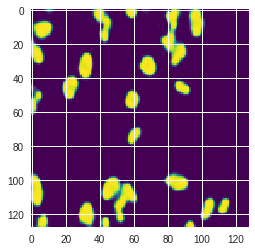

In [192]:
plt.imshow(preds[1].reshape(128, 128), cmap='viridis')

In [0]:
preds = (preds > 0.5).astype(np.uint8)

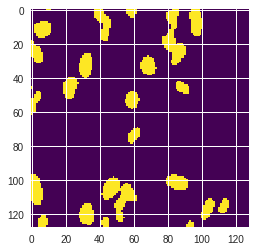

In [194]:
plt.imshow(preds[1].reshape(128, 128), cmap='viridis')

In [0]:
preds_test_upsampled = []
for i in range(len(preds)):
    preds_test_upsampled.append(resize(np.squeeze(preds[i]), x_test_sizes[i], mode='constant', preserve_range=True))

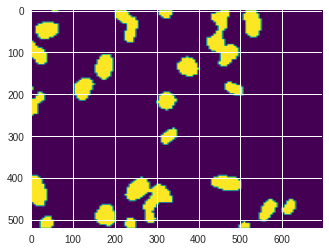

In [196]:
plt.imshow(preds_test_upsampled[1], cmap='viridis')

In [0]:
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [0]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

In [199]:
len(test_ids), len(new_test_ids)

(65, 2056)

In [0]:
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('submission.csv', index=False)

In [201]:
sub['ImageId'].nunique()

65

In [202]:
sub.head()

,ImageId,EncodedPixels
0,4f949bd8d914bbfa06f40d6a0e2b5b75c38bf53dbcbafc...,23 35 412 38 802 43 1192 44 1582 52 1972 52 23...
1,4f949bd8d914bbfa06f40d6a0e2b5b75c38bf53dbcbafc...,50366 3 50756 4 51146 9 51535 11 51923 15 5231...
2,4f949bd8d914bbfa06f40d6a0e2b5b75c38bf53dbcbafc...,41009 6 41399 8 41789 9 42177 11 42566 12 4295...
3,4f949bd8d914bbfa06f40d6a0e2b5b75c38bf53dbcbafc...,45314 9 45703 10 46091 12 46481 12 46871 12 47...
4,4f949bd8d914bbfa06f40d6a0e2b5b75c38bf53dbcbafc...,50390 9 50779 11 51164 21 51554 21 51944 21 52...


In [0]:
from google.colab import files
files.download('./submission.csv')